# Report
## What is outlier
(I did not visit last lab session and don't know all the details)  
In my opinion outlier is a sample with outstanding weight.  That means the outlier obtains too high value after all iterations.  
I measure __outstanding__ weight by its deviation from mean value of the sample.  

## Approach
### What to do with nan?
1) Simpliest solution - drop all nan values. That leads to lose of ~40 countries from entire dataset, it is quite huge (~20%)  
2) Another simple solution - assign 0 to nans. `df.fillna(0)` This solution affects mean & deviation values, don't like it.  
3) My solution - set average values based on belonging to specific region. `Literacy (%)[Guernsey] = avg(Literacy (%), Europe)`    

### How to get sample weights?
In order to obtain sample weights I inherited from AdaBoostClassifier and store sample weights in additional container.  
`self.sample_container = []`  
### How do I measure outlier?
1) Standartize the values of RV (last iteration's sample weights) `X∼N(μ,σ2)`  
2) Apply formula (W - μ) / σ  _W - vector of weights_  
3) Interpret outliers as values that are larger than two standard deviations, link to the [article](http://www.brendangregg.com/Articles/Detecting_Outliers.pdf)  
    - Outliers = { val ∈ W | val > (μ + kσ)}
    - A value of `k` is a hyperparameter, that should be chosen carefully  
    
#### Output examples
<details>
<summary>This combination provides best improvement of accuracy. K=[2], ESTIMATORS=[25], algorithm='SAMME'</summary>
<br>
Score with outliers equals = [0.927]  
Score w/o outliers equals = [0.984]  
  
Found [9] outliers  
- Albania  
- Ireland  
- Italy  
- Japan  
- Lesotho  
- Rwanda  
- San Marino  
- Turkmenistan  
- Uruguay  
</details>
<details>
<summary>Not enough time for the model. K=[3], ESTIMATORS=[10], algorithm='SAMME'</summary>
<br>
Score with outliers equals = [0.913] - __as you can see here, the model did not have enough time to train__  
Score w/o outliers equals = [0.940] - that leads to 3% improvement, but not the best  
  
Found [6] outliers  
- Ireland  
- Japan  
- Lesotho   
- Rwanda   
- San Marino   
- Uruguay  
</details>

#### Justification of the results:
This plot represents standartized sample weights (blue) and sigma values (red) [1, 2, 3, 6]  
We can see the distribution and find sample outliers

![Plot](https://pp.userapi.com/c844618/v844618794/11922c/JQt4-LT4I3Y.jpg)

### Post Scriptum
- Test fraction equals to 0.3
- Only default method was used in AdaBoostClassifier _(Decision Tree)_  
- With K=0 model proposes best results with 100% accuracy, but it is silly. Model loses ~50 countries. We will not treat it as a winner.
- Cases with K=6 identify astonishing outliers and increase the accuracy of the model, but only if #estimators is big enough (not equal to 10).
- It is also possible to measure results by altering learning rate, but we are analyzing __outliers__, not AdaBoost performance.  



In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
class AdaTree(AdaBoostClassifier):
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):
        super().__init__(base_estimator=base_estimator,
                                                n_estimators=n_estimators,
                                                learning_rate=learning_rate,
                                                algorithm=algorithm,
                                                random_state=random_state)
        self.sample_container = []
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        self.sample_container.append(sample_weight)
        return super()._boost(iboost, X, y, sample_weight, random_state)


In [13]:
def fix_column(df, column):
    averages = {}
    amount = {}
    df[column] = df[column].fillna(0)
    
    regions = np.unique(df['Region'].values)
    for c in regions:
        averages[c] = 0
        amount[c] = 0
    fix_indexes = []
    
    for i in range(len(df)):
        region = df.loc[i, 'Region']
        value = df.loc[i, column]
        if value != 0:
            averages[region] += value
            amount[region] += 1
        else:
            fix_indexes.append(i)
    
    for reg in regions:
        averages[reg] /= amount[reg]
    
    for fix in fix_indexes:
        region = df.loc[fix, 'Region']
        value = averages[region]
        df.loc[fix, column] = value
        
    return df
        
def fix_columns(df, columns):
    print(columns)
    for column in columns:
        df = fix_column(df, column)
    return df
        

In [14]:
dataset = pd.read_csv('datasets/countries.csv')
# dataset = dataset.dropna()
# dataset = fix_column(dataset, 'Climate')
# dataset = fix_column(dataset, 'Agriculture')
# dataset = fix_column(dataset, 'Industry')
# dataset = fix_column(dataset, 'Service')
# dataset = fix_column(dataset, 'Birthrate')
# dataset = fix_column(dataset, 'Deathrate')
# dataset = fix_column(dataset, 'GDP ($ per capita)')
dataset = fix_columns(dataset, [item for item in dataset.columns.values if item not in ['Region', 'Country']])

print(dataset.dtypes)



dataset['Region'] = dataset.Region.apply(lambda x: x.replace('EUROPE', '1'))
dataset['Region'] = dataset.Region.apply(lambda x: x.replace('ASIA', '-1'))
dataset['Region'] = dataset.Region.apply(lambda x: x.replace('AMERICA', '-1'))
dataset['Region'] = dataset.Region.apply(lambda x: x.replace('AFRICA', '-1'))
dataset['Region'] = dataset.Region.apply(lambda x: x.replace('OCEANIA', '-1'))
dataset['Region'] = dataset['Region'].astype('float64')

y = dataset[['Region']]
X = dataset[[val for val in dataset.columns.values if val not in ['Region', 'Country']]]

['Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration', 'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)', 'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service', 'GDP ($ per capita)']
Country                                object
Region                                 object
Population                              int64
Area (sq. mi.)                          int64
Pop. Density (per sq. mi.)            float64
Coastline (coast/area ratio)          float64
Net migration                         float64
Infant mortality (per 1000 births)    float64
Literacy (%)                          float64
Phones (per 1000)                     float64
Arable (%)                            float64
Crops (%)                             float64
Other (%)                             float64
Climate                               float64
Birthrate                       

In [81]:
def ada_makemagic(X, y, k=2, n_estimators=25, method=None):
    print("#" * 15)
    print("Task to detect outliers & reexecute w/o them. K=[{}], ESTIMATORS=[{}]".format(k, n_estimators))
    ada = AdaTree(n_estimators=n_estimators, learning_rate=1.0, algorithm='SAMME')
    ada.fit(X, y)
    
    train_xc, test_xc, train_yc, test_yc = train_test_split(X, y, test_size=0.3)
    ada_classic = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.0, algorithm='SAMME')
    ada_classic.fit(train_xc, train_yc)
    score_classic = ada_classic.score(test_xc, test_yc)
    print("Score with outliers equals = [{}]".format(score_classic))

    # Search for outliers
    sample_weights = ada.sample_container
    last_weights = sample_weights[-1]
    mean = np.mean(last_weights)
    std = np.std(last_weights)
    standartized_weights = (last_weights - mean) / std
    
    outliers = []
    for (index, val) in enumerate(last_weights):
        if mean + k * std < val:
            outliers.append(index)
        
    outl_names = dataset.loc[outliers, 'Country']
#     print(outl_names.values)
    print('Found [{}] outliers, burn them all'.format(len(outl_names)))
    
    dfx = X.drop(outliers)
    dfy = y.drop(outliers)
    train_x, test_x, train_y, test_y = train_test_split(dfx, dfy, test_size=0.3)
    mega_ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.0, algorithm='SAMME')
    mega_ada.fit(train_x, train_y)
    
    score_wo = mega_ada.score(test_x, test_y)

    print("Score w/o outliers equals = [{}]".format(score_wo))   
    return standartized_weights

In [65]:
estimators = [10, 25, 50, 100]
ks = [0, 2, 3, 6]
for n_est in estimators:
    for k in ks:
        ada_makemagic(X, y, k=k, n_estimators=n_est)


###############
Task to detect outliers & reexecute w/o them. K=[0], ESTIMATORS=[10]
Score with outliers equals = [0.9565217391304348]
Found [46] outliers, burn them all
Score w/o outliers equals = [1.0]
###############
Task to detect outliers & reexecute w/o them. K=[2], ESTIMATORS=[10]
Score with outliers equals = [0.8695652173913043]
Found [8] outliers, burn them all
Score w/o outliers equals = [0.9393939393939394]
###############
Task to detect outliers & reexecute w/o them. K=[3], ESTIMATORS=[10]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score with outliers equals = [0.9565217391304348]
Found [6] outliers, burn them all
Score w/o outliers equals = [0.9402985074626866]
###############
Task to detect outliers & reexecute w/o them. K=[6], ESTIMATORS=[10]
Score with outliers equals = [0.9420289855072463]
Found [3] outliers, burn them all
Score w/o outliers equals = [0.9264705882352942]
###############
Task to detect outliers & reexecute w/o them. K=[0], ESTIMATORS=[25]
Score with outliers equals = [0.9420289855072463]
Found [57] outliers, burn them all


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score w/o outliers equals = [0.9803921568627451]
###############
Task to detect outliers & reexecute w/o them. K=[2], ESTIMATORS=[25]
Score with outliers equals = [0.9420289855072463]
Found [9] outliers, burn them all
Score w/o outliers equals = [0.9848484848484849]
###############
Task to detect outliers & reexecute w/o them. K=[3], ESTIMATORS=[25]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score with outliers equals = [0.9855072463768116]
Found [6] outliers, burn them all
Score w/o outliers equals = [0.9402985074626866]
###############
Task to detect outliers & reexecute w/o them. K=[6], ESTIMATORS=[25]
Score with outliers equals = [0.9420289855072463]
Found [2] outliers, burn them all
Score w/o outliers equals = [0.9852941176470589]
###############
Task to detect outliers & reexecute w/o them. K=[0], ESTIMATORS=[50]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score with outliers equals = [0.9420289855072463]
Found [55] outliers, burn them all
Score w/o outliers equals = [1.0]
###############
Task to detect outliers & reexecute w/o them. K=[2], ESTIMATORS=[50]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score with outliers equals = [0.9855072463768116]
Found [9] outliers, burn them all
Score w/o outliers equals = [0.9848484848484849]
###############
Task to detect outliers & reexecute w/o them. K=[3], ESTIMATORS=[50]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score with outliers equals = [0.8985507246376812]
Found [7] outliers, burn them all
Score w/o outliers equals = [1.0]
###############
Task to detect outliers & reexecute w/o them. K=[6], ESTIMATORS=[50]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score with outliers equals = [0.9565217391304348]
Found [1] outliers, burn them all
Score w/o outliers equals = [0.9558823529411765]
###############
Task to detect outliers & reexecute w/o them. K=[0], ESTIMATORS=[100]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score with outliers equals = [0.9420289855072463]
Found [46] outliers, burn them all
Score w/o outliers equals = [1.0]
###############
Task to detect outliers & reexecute w/o them. K=[2], ESTIMATORS=[100]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score with outliers equals = [0.9420289855072463]
Found [10] outliers, burn them all
Score w/o outliers equals = [0.9848484848484849]
###############
Task to detect outliers & reexecute w/o them. K=[3], ESTIMATORS=[100]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score with outliers equals = [0.9565217391304348]
Found [4] outliers, burn them all
Score w/o outliers equals = [0.9402985074626866]
###############
Task to detect outliers & reexecute w/o them. K=[6], ESTIMATORS=[100]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Score with outliers equals = [0.9420289855072463]
Found [2] outliers, burn them all
Score w/o outliers equals = [0.9558823529411765]


NameError: name 'standartized_weights' is not defined

###############
Task to detect outliers & reexecute w/o them. K=[2], ESTIMATORS=[25]
Score with outliers equals = [0.9420289855072463]
Found [9] outliers, burn them all
Score w/o outliers equals = [0.9848484848484849]


C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\evger\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


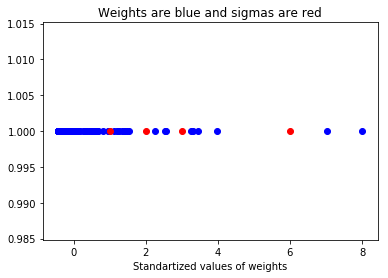

In [84]:
weights = ada_makemagic(X, y)
ys = [1] * len(weights)
sigma = np.std(weights)
sigmas = [sigma, sigma * 2, sigma * 3, sigma * 6]
plt.scatter(weights, ys, c='b')
plt.scatter(sigmas, [1, 1, 1, 1], c='r')
plt.xlabel('Standartized values of weights')
plt.title('Weights are blue and sigmas are red')  # skies are blue and clouds are white
plt.show()